<a href="https://colab.research.google.com/github/Coldestadam/DynamicHead/blob/master/torch/DyHead_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn

# Grabbing a random Image

(729, 486)


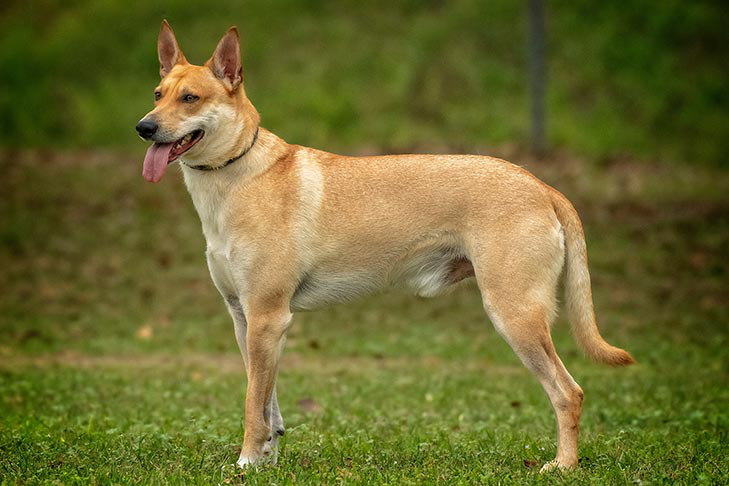

In [15]:
import urllib.request
import PIL.Image as Image
# Looking at an image
img_url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg"
urllib.request.urlretrieve(img_url, 'dog.jpg')

img = Image.open('dog.jpg')
print(img.size)
img

# Transforming image

Resizing image to (224, 224) because of the input size of ResNet Models

In [16]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

img_tensor = transform(img).unsqueeze(dim=0)
print(img_tensor.shape)

torch.Size([1, 3, 224, 224])


# Importing Resnet model with FPN Backbone

In [17]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone_name = 'resnet50'
backbone = resnet_fpn_backbone(backbone_name=backbone_name, pretrained=True)

# Going through each step in a forward pass through each step of Figure 1.

![img](https://github.com/Coldestadam/DynamicHead/blob/master/imgs/Figure_1.png?raw=true)

In [18]:
# Passing image through backbone
F = backbone(img_tensor)
print(type(F))

num_levels = 0
# F contains all the outputs of the Feature Pyramid Network
for level, level_tensor in F.items():
    print('Level: {} \t Shape: {}'.format(level, level_tensor.shape))

    try:
        if isinstance(int(level), int):
            num_levels+=1
    except ValueError:
        pass
print('{} total levels'.format(num_levels))


<class 'collections.OrderedDict'>
Level: 0 	 Shape: torch.Size([1, 256, 56, 56])
Level: 1 	 Shape: torch.Size([1, 256, 28, 28])
Level: 2 	 Shape: torch.Size([1, 256, 14, 14])
Level: 3 	 Shape: torch.Size([1, 256, 7, 7])
Level: pool 	 Shape: torch.Size([1, 256, 4, 4])
4 total levels


## Defining concatenation layer

This will upsample or downsample each level to the median Height and Width

In [19]:
import numpy as np
from concat_fpn_output import concat_feature_maps
concat_layer = concat_feature_maps()
F = concat_layer(F)
print('Shape: {}'.format(F.shape))

L, S, C = F.shape[1:]
print('Median HeightxWidth: {}x{}'.format(int(np.sqrt(S)), int(np.sqrt(S))))
print("F Dimensions\nL: {} S: {} C: {}".format(L, S, C))

Shape: torch.Size([1, 4, 441, 256])
Median HeightxWidth: 21x21
F Dimensions
L: 4 S: 441 C: 256


## Defining Scale-aware Attention Layer

![scale_img](https://github.com/Coldestadam/DynamicHead/blob/master/imgs/scale_attention.png?raw=true)

In [20]:
from attention_layers import Scale_Aware_Layer

scale_layer = Scale_Aware_Layer(s_size=S)
scale_output = scale_layer(F)
print(f'Shape of scale output: {scale_output.shape}')

Shape of scale output: torch.Size([1, 4, 441, 256])


## Defining Spatial-aware Attention Layer
![spatial_img](https://github.com/Coldestadam/DynamicHead/blob/master/imgs/spatial_attention.png?raw=true)

In [21]:
from attention_layers import Spatial_Aware_Layer

spatial_layer = Spatial_Aware_Layer(L_size=L)
spatial_output = spatial_layer(scale_output)
print(f'Shape of scale output: {spatial_output.shape}')

Shape of scale output: torch.Size([1, 4, 441, 256])


## Defining Task-aware Attention Layer

![task_image](https://github.com/Coldestadam/DynamicHead/blob/master/imgs/task_aware.png?raw=true)

In [22]:
from attention_layers import Task_Aware_Layer

task_layer = Task_Aware_Layer(num_channels=C)
task_output = task_layer(spatial_output)
print(f'Shape of scale output: {task_output.shape}')

Shape of scale output: torch.Size([1, 4, 441, 256])


# Contructing a single DyHead Block

![DyHead img](https://github.com/Coldestadam/DynamicHead/blob/master/imgs/DyHead_Block.png?raw=true)

In [23]:
from DyHead import DyHead_Block

dyhead_block = DyHead_Block(L=L, S=S, C=C)
print(dyhead_block)

DyHead_Block(
  (scale_attention): Scale_Aware_Layer(
    (avg_layer): AvgPool2d(kernel_size=3, stride=1, padding=1)
    (conv): Conv2d(441, 1, kernel_size=(1, 1), stride=(1, 1))
    (hard_sigmoid): Hardsigmoid()
    (relu): ReLU()
  )
  (spatial_attention): Spatial_Aware_Layer(
    (offset_and_mask_conv): Conv2d(4, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deform_conv): DeformConv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (task_attention): Task_Aware_Layer(
    (dynamic_relu): DyReLUA(
      (fc1): Linear(in_features=256, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=4, bias=True)
      (relu): ReLU(inplace=True)
      (sigmoid): Sigmoid()
    )
  )
)


# Constructing a DyHead

In [24]:
from DyHead import DyHead

num_blocks = 6 # This is the baseline given in the paper
full_head = DyHead(num_blocks, L, S, C)
print(full_head)

Sequential(
  (Block_1): DyHead_Block(
    (scale_attention): Scale_Aware_Layer(
      (avg_layer): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (conv): Conv2d(441, 1, kernel_size=(1, 1), stride=(1, 1))
      (hard_sigmoid): Hardsigmoid()
      (relu): ReLU()
    )
    (spatial_attention): Spatial_Aware_Layer(
      (offset_and_mask_conv): Conv2d(4, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (deform_conv): DeformConv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (task_attention): Task_Aware_Layer(
      (dynamic_relu): DyReLUA(
        (fc1): Linear(in_features=256, out_features=32, bias=True)
        (fc2): Linear(in_features=32, out_features=4, bias=True)
        (relu): ReLU(inplace=True)
        (sigmoid): Sigmoid()
      )
    )
  )
  (Block_2): DyHead_Block(
    (scale_attention): Scale_Aware_Layer(
      (avg_layer): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (conv): Conv2d(441, 1, kernel_size=(1, 1), stride=(1, 1))
      